In [49]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import os
import scipy as sp
import random
import warnings
import string
import imutils
import datetime
from spellchecker import SpellChecker
from PIL import Image, ImageDraw, ImageOps
warnings.filterwarnings("ignore")
%matplotlib inline

import tensorflow as tf
from keras import backend as K
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Reshape, Bidirectional, LSTM, Dense, Lambda, Activation, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam

In [2]:
# Load the data A.S
train_name = pd.read_csv('D:/WorkStation/Datasets/archive/written_name_train_v2.csv')
test_name = pd.read_csv('D:/WorkStation/Datasets/archive/written_name_test_v2.csv')
val_name = pd.read_csv('D:/WorkStation/Datasets/archive/written_name_validation_v2.csv')

In [3]:
train_name.head()

,FILENAME,IDENTITY
0,TRAIN_00001.jpg,BALTHAZAR
1,TRAIN_00002.jpg,SIMON
2,TRAIN_00003.jpg,BENES
3,TRAIN_00004.jpg,LA LOVE
4,TRAIN_00005.jpg,DAPHNE


In [4]:
train_name.describe()

,FILENAME,IDENTITY
count,330961,330396
unique,330961,100539
top,TRAIN_00001.jpg,THOMAS
freq,1,1825


In [5]:
test_name.describe()

,FILENAME,IDENTITY
count,41370,41300
unique,41370,20279
top,TEST_0001.jpg,THOMAS
freq,1,227


In [6]:
train_name.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 330961 entries, 0 to 330960
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   FILENAME  330961 non-null  object
 1   IDENTITY  330396 non-null  object
dtypes: object(2)
memory usage: 5.1+ MB


In [7]:
test_name.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41370 entries, 0 to 41369
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   FILENAME  41370 non-null  object
 1   IDENTITY  41300 non-null  object
dtypes: object(2)
memory usage: 646.5+ KB


In [8]:
train_name.shape

(330961, 2)

In [9]:
test_name.shape

(41370, 2)

In [10]:
val_name.shape

(41370, 2)

In [11]:
train_name.dtypes

FILENAME    object
IDENTITY    object
dtype: object

In [12]:
train_name.columns

Index(['FILENAME', 'IDENTITY'], dtype='object')

D:/WorkStation/Datasets/archive/train_v2/train/TRAIN_00001.jpg
D:/WorkStation/Datasets/archive/train_v2/train/TRAIN_00002.jpg
D:/WorkStation/Datasets/archive/train_v2/train/TRAIN_00003.jpg
D:/WorkStation/Datasets/archive/train_v2/train/TRAIN_00004.jpg
D:/WorkStation/Datasets/archive/train_v2/train/TRAIN_00005.jpg
D:/WorkStation/Datasets/archive/train_v2/train/TRAIN_00006.jpg


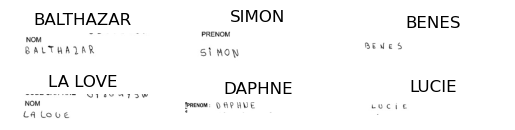

In [13]:
for i in range(6):
    ax = plt.subplot(2, 3, i+1)
    img_dir = 'D:/WorkStation/Datasets/archive/train_v2/train/'+train_name.loc[i, 'FILENAME']
    print(img_dir)
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    plt.imshow(image, cmap = 'gray')
    plt.title(train_name.loc[i, 'IDENTITY'], fontsize=12)
    plt.axis('off')
    
plt.subplots_adjust(wspace=0.2, hspace=-0.8)

In [14]:
print("Number of NaNs in the train dataset is: ", train_name['IDENTITY'].isnull().sum())
print("Number of NaNs in the validation dataset is: ", val_name['IDENTITY'].isnull().sum())
print("Number of NaNs in the test dataset is: ", test_name['IDENTITY'].isnull().sum())

Number of NaNs in the train dataset is:  565
Number of NaNs in the validation dataset is:  78
Number of NaNs in the test dataset is:  70


In [15]:
# Drop rows with missing labels A.S
train_name.dropna(axis=0, inplace=True)
val_name.dropna(axis=0, inplace=True)
test_name.dropna(axis=0, inplace=True)

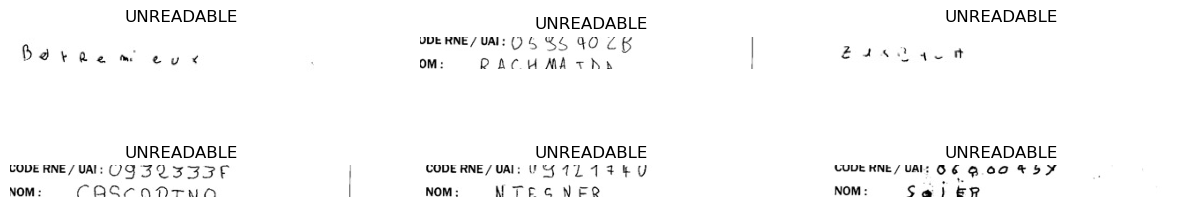

In [16]:
unreadable = train_name[train_name['IDENTITY'] == 'UNREADABLE']
unreadable.reset_index(inplace = True, drop = True)

plt.figure(figsize=(15,10))

for i in range(6):
    ax = plt.subplot(2, 3, i+1)
    img_dir = 'D:/WorkStation/Datasets/archive/train_v2/train/'+unreadable.loc[i, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    plt.imshow(image, cmap = 'gray')
    plt.title(unreadable.loc[i, 'IDENTITY'], fontsize=12)
    plt.axis('off')
    
plt.subplots_adjust(wspace=0.2, hspace=-0.8)

In [17]:
# Remove unreadable images A.S
train_name = train_name[train_name['IDENTITY'] != 'UNREADABLE']
val_name = val_name[val_name['IDENTITY'] != 'UNREADABLE']
test_name = test_name[test_name['IDENTITY'] != 'UNREADABLE']

In [18]:
# Convert labels to uppercase A.S
train_name['IDENTITY'] = train_name['IDENTITY'].str.upper()
val_name['IDENTITY'] = val_name['IDENTITY'].str.upper()
test_name['IDENTITY'] = test_name['IDENTITY'].str.upper()

In [19]:
# Reset the index A.S
train_name.reset_index(inplace = True, drop = True)
val_name.reset_index(inplace = True, drop = True)
test_name.reset_index(inplace = True, drop = True)

In [20]:
def increaseImageQuality(img):
    # Check image type and convert if necessary
    if img.dtype != np.uint8:
        img = np.uint8(img / np.max(img) * 255)
    # Increase the contrast of the image
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    img = clahe.apply(img)

    # Sharpen the image
    kernel = np.array([[-1,-1,-1],[-1,9,-1],[-1,-1,-1]])
    img = cv2.filter2D(img, -1, kernel)
    
    return img

In [21]:
def preprocessImage(img):
    (h, w) = img.shape

    # Calculate the new size while preserving the aspect ratio
    max_width = 256
    max_height = 64
    aspect_ratio = float(img.shape[1]) / img.shape[0]
    new_width = int(max_height * aspect_ratio)
    new_height = max_height

    if new_width > max_width:
        new_width = max_width
        new_height = int(new_width / aspect_ratio)

    # Ensure that the new height is at least 31 pixels
    if new_height < 31:
        new_height = 31
        new_width = int(new_height * aspect_ratio)

    # Resize the image
    if h < max_height and w < max_width:
        resized_image = img
    else:
        resized_image = imutils.resize(image, width = 256, height = 64)

    # Calculate the padding values
    top = max(0, (h - new_height) // 2)
    bottom = max(0, h - new_height - top)
    left = max(0, (w - new_width) // 2)
    right = max(0, w - new_width - left)

    # Add padding if necessary
    resized_image_with_padding = resized_image
    #resized_image_with_padding = cv2.copyMakeBorder(resized_image, top, bottom, left, right, cv2.BORDER_CONSTANT, value=(255, 255, 255))

    # Create a blank white image with the final size
    final_img = np.ones([64, 256])*255 

    # Resize the padded image to fit the final size
    resized_padded_image = cv2.resize(resized_image_with_padding, (256, 64), interpolation=cv2.INTER_AREA)

    # Copy the resized padded image to the final image
    final_img[:resized_padded_image.shape[0], :resized_padded_image.shape[1]] = resized_padded_image
    final_img = increaseImageQuality(final_img)
    # Rotate the final image 90 degrees clockwise
    final_img = cv2.rotate(final_img, cv2.ROTATE_90_CLOCKWISE)
    cv2.imwrite('test.png',final_img)
    return final_img

In [26]:
def cropImage(im):
    # Get rid of existing black border by flood-filling with white from top-left corner
    ImageDraw.floodfill(im,xy=(0,0),value=(255,255,255),thresh=10)

    # Get bounding box of text and trim to it
    bbox = ImageOps.invert(im).getbbox()
    trimmed = im.crop(bbox)

    # Add new white border, then new black, then new white border
    res = ImageOps.expand(trimmed, border=1, fill=(255,255,255))
#     res = ImageOps.expand(res, border=5, fill=(255,255,255))
#     res = ImageOps.expand(res, border=5, fill=(255,255,255))
    res.save('result.png')
    return res

In [45]:
def autocorrect(prediction):
    my_file = open("WordsDictionary.txt", "r")
    # reading the file
    data = my_file.read()

    # replacing end of line('/n') with ' ' and
    # splitting the text it further when '.' is seen.
    data_into_list = data.split("\n")
    #print(data_into_list)
    spell = SpellChecker()
    spell.word_frequency.load_words(data_into_list)
    word = spell.correction(prediction)
    word = word.upper()
    return word

In [27]:
train_size = 30000
valid_size= 10000

In [28]:
train_x = []
for i in range(train_size):
    print(i)
    img_dir = 'D:/WorkStation/Datasets/archive/train_v2/train/'+train_name.loc[i, 'FILENAME']
    image = Image.open(img_dir)
    image = cropImage(image)
    image = cv2.imread('result.png', cv2.IMREAD_GRAYSCALE)
    image = preprocessImage(image)
    image = image/255.
    train_x.append(image)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060
2061
2062
2063
2064
2065
2066
2067
2068
2069
2070
2071
2072


3515
3516
3517
3518
3519
3520
3521
3522
3523
3524
3525
3526
3527
3528
3529
3530
3531
3532
3533
3534
3535
3536
3537
3538
3539
3540
3541
3542
3543
3544
3545
3546
3547
3548
3549
3550
3551
3552
3553
3554
3555
3556
3557
3558
3559
3560
3561
3562
3563
3564
3565
3566
3567
3568
3569
3570
3571
3572
3573
3574
3575
3576
3577
3578
3579
3580
3581
3582
3583
3584
3585
3586
3587
3588
3589
3590
3591
3592
3593
3594
3595
3596
3597
3598
3599
3600
3601
3602
3603
3604
3605
3606
3607
3608
3609
3610
3611
3612
3613
3614
3615
3616
3617
3618
3619
3620
3621
3622
3623
3624
3625
3626
3627
3628
3629
3630
3631
3632
3633
3634
3635
3636
3637
3638
3639
3640
3641
3642
3643
3644
3645
3646
3647
3648
3649
3650
3651
3652
3653
3654
3655
3656
3657
3658
3659
3660
3661
3662
3663
3664
3665
3666
3667
3668
3669
3670
3671
3672
3673
3674
3675
3676
3677
3678
3679
3680
3681
3682
3683
3684
3685
3686
3687
3688
3689
3690
3691
3692
3693
3694
3695
3696
3697
3698
3699
3700
3701
3702
3703
3704
3705
3706
3707
3708
3709
3710
3711
3712
3713
3714


5165
5166
5167
5168
5169
5170
5171
5172
5173
5174
5175
5176
5177
5178
5179
5180
5181
5182
5183
5184
5185
5186
5187
5188
5189
5190
5191
5192
5193
5194
5195
5196
5197
5198
5199
5200
5201
5202
5203
5204
5205
5206
5207
5208
5209
5210
5211
5212
5213
5214
5215
5216
5217
5218
5219
5220
5221
5222
5223
5224
5225
5226
5227
5228
5229
5230
5231
5232
5233
5234
5235
5236
5237
5238
5239
5240
5241
5242
5243
5244
5245
5246
5247
5248
5249
5250
5251
5252
5253
5254
5255
5256
5257
5258
5259
5260
5261
5262
5263
5264
5265
5266
5267
5268
5269
5270
5271
5272
5273
5274
5275
5276
5277
5278
5279
5280
5281
5282
5283
5284
5285
5286
5287
5288
5289
5290
5291
5292
5293
5294
5295
5296
5297
5298
5299
5300
5301
5302
5303
5304
5305
5306
5307
5308
5309
5310
5311
5312
5313
5314
5315
5316
5317
5318
5319
5320
5321
5322
5323
5324
5325
5326
5327
5328
5329
5330
5331
5332
5333
5334
5335
5336
5337
5338
5339
5340
5341
5342
5343
5344
5345
5346
5347
5348
5349
5350
5351
5352
5353
5354
5355
5356
5357
5358
5359
5360
5361
5362
5363
5364


6814
6815
6816
6817
6818
6819
6820
6821
6822
6823
6824
6825
6826
6827
6828
6829
6830
6831
6832
6833
6834
6835
6836
6837
6838
6839
6840
6841
6842
6843
6844
6845
6846
6847
6848
6849
6850
6851
6852
6853
6854
6855
6856
6857
6858
6859
6860
6861
6862
6863
6864
6865
6866
6867
6868
6869
6870
6871
6872
6873
6874
6875
6876
6877
6878
6879
6880
6881
6882
6883
6884
6885
6886
6887
6888
6889
6890
6891
6892
6893
6894
6895
6896
6897
6898
6899
6900
6901
6902
6903
6904
6905
6906
6907
6908
6909
6910
6911
6912
6913
6914
6915
6916
6917
6918
6919
6920
6921
6922
6923
6924
6925
6926
6927
6928
6929
6930
6931
6932
6933
6934
6935
6936
6937
6938
6939
6940
6941
6942
6943
6944
6945
6946
6947
6948
6949
6950
6951
6952
6953
6954
6955
6956
6957
6958
6959
6960
6961
6962
6963
6964
6965
6966
6967
6968
6969
6970
6971
6972
6973
6974
6975
6976
6977
6978
6979
6980
6981
6982
6983
6984
6985
6986
6987
6988
6989
6990
6991
6992
6993
6994
6995
6996
6997
6998
6999
7000
7001
7002
7003
7004
7005
7006
7007
7008
7009
7010
7011
7012
7013


8467
8468
8469
8470
8471
8472
8473
8474
8475
8476
8477
8478
8479
8480
8481
8482
8483
8484
8485
8486
8487
8488
8489
8490
8491
8492
8493
8494
8495
8496
8497
8498
8499
8500
8501
8502
8503
8504
8505
8506
8507
8508
8509
8510
8511
8512
8513
8514
8515
8516
8517
8518
8519
8520
8521
8522
8523
8524
8525
8526
8527
8528
8529
8530
8531
8532
8533
8534
8535
8536
8537
8538
8539
8540
8541
8542
8543
8544
8545
8546
8547
8548
8549
8550
8551
8552
8553
8554
8555
8556
8557
8558
8559
8560
8561
8562
8563
8564
8565
8566
8567
8568
8569
8570
8571
8572
8573
8574
8575
8576
8577
8578
8579
8580
8581
8582
8583
8584
8585
8586
8587
8588
8589
8590
8591
8592
8593
8594
8595
8596
8597
8598
8599
8600
8601
8602
8603
8604
8605
8606
8607
8608
8609
8610
8611
8612
8613
8614
8615
8616
8617
8618
8619
8620
8621
8622
8623
8624
8625
8626
8627
8628
8629
8630
8631
8632
8633
8634
8635
8636
8637
8638
8639
8640
8641
8642
8643
8644
8645
8646
8647
8648
8649
8650
8651
8652
8653
8654
8655
8656
8657
8658
8659
8660
8661
8662
8663
8664
8665
8666


10089
10090
10091
10092
10093
10094
10095
10096
10097
10098
10099
10100
10101
10102
10103
10104
10105
10106
10107
10108
10109
10110
10111
10112
10113
10114
10115
10116
10117
10118
10119
10120
10121
10122
10123
10124
10125
10126
10127
10128
10129
10130
10131
10132
10133
10134
10135
10136
10137
10138
10139
10140
10141
10142
10143
10144
10145
10146
10147
10148
10149
10150
10151
10152
10153
10154
10155
10156
10157
10158
10159
10160
10161
10162
10163
10164
10165
10166
10167
10168
10169
10170
10171
10172
10173
10174
10175
10176
10177
10178
10179
10180
10181
10182
10183
10184
10185
10186
10187
10188
10189
10190
10191
10192
10193
10194
10195
10196
10197
10198
10199
10200
10201
10202
10203
10204
10205
10206
10207
10208
10209
10210
10211
10212
10213
10214
10215
10216
10217
10218
10219
10220
10221
10222
10223
10224
10225
10226
10227
10228
10229
10230
10231
10232
10233
10234
10235
10236
10237
10238
10239
10240
10241
10242
10243
10244
10245
10246
10247
10248
10249
10250
10251
10252
10253
10254
1025

11457
11458
11459
11460
11461
11462
11463
11464
11465
11466
11467
11468
11469
11470
11471
11472
11473
11474
11475
11476
11477
11478
11479
11480
11481
11482
11483
11484
11485
11486
11487
11488
11489
11490
11491
11492
11493
11494
11495
11496
11497
11498
11499
11500
11501
11502
11503
11504
11505
11506
11507
11508
11509
11510
11511
11512
11513
11514
11515
11516
11517
11518
11519
11520
11521
11522
11523
11524
11525
11526
11527
11528
11529
11530
11531
11532
11533
11534
11535
11536
11537
11538
11539
11540
11541
11542
11543
11544
11545
11546
11547
11548
11549
11550
11551
11552
11553
11554
11555
11556
11557
11558
11559
11560
11561
11562
11563
11564
11565
11566
11567
11568
11569
11570
11571
11572
11573
11574
11575
11576
11577
11578
11579
11580
11581
11582
11583
11584
11585
11586
11587
11588
11589
11590
11591
11592
11593
11594
11595
11596
11597
11598
11599
11600
11601
11602
11603
11604
11605
11606
11607
11608
11609
11610
11611
11612
11613
11614
11615
11616
11617
11618
11619
11620
11621
11622
1162

12828
12829
12830
12831
12832
12833
12834
12835
12836
12837
12838
12839
12840
12841
12842
12843
12844
12845
12846
12847
12848
12849
12850
12851
12852
12853
12854
12855
12856
12857
12858
12859
12860
12861
12862
12863
12864
12865
12866
12867
12868
12869
12870
12871
12872
12873
12874
12875
12876
12877
12878
12879
12880
12881
12882
12883
12884
12885
12886
12887
12888
12889
12890
12891
12892
12893
12894
12895
12896
12897
12898
12899
12900
12901
12902
12903
12904
12905
12906
12907
12908
12909
12910
12911
12912
12913
12914
12915
12916
12917
12918
12919
12920
12921
12922
12923
12924
12925
12926
12927
12928
12929
12930
12931
12932
12933
12934
12935
12936
12937
12938
12939
12940
12941
12942
12943
12944
12945
12946
12947
12948
12949
12950
12951
12952
12953
12954
12955
12956
12957
12958
12959
12960
12961
12962
12963
12964
12965
12966
12967
12968
12969
12970
12971
12972
12973
12974
12975
12976
12977
12978
12979
12980
12981
12982
12983
12984
12985
12986
12987
12988
12989
12990
12991
12992
12993
1299

14197
14198
14199
14200
14201
14202
14203
14204
14205
14206
14207
14208
14209
14210
14211
14212
14213
14214
14215
14216
14217
14218
14219
14220
14221
14222
14223
14224
14225
14226
14227
14228
14229
14230
14231
14232
14233
14234
14235
14236
14237
14238
14239
14240
14241
14242
14243
14244
14245
14246
14247
14248
14249
14250
14251
14252
14253
14254
14255
14256
14257
14258
14259
14260
14261
14262
14263
14264
14265
14266
14267
14268
14269
14270
14271
14272
14273
14274
14275
14276
14277
14278
14279
14280
14281
14282
14283
14284
14285
14286
14287
14288
14289
14290
14291
14292
14293
14294
14295
14296
14297
14298
14299
14300
14301
14302
14303
14304
14305
14306
14307
14308
14309
14310
14311
14312
14313
14314
14315
14316
14317
14318
14319
14320
14321
14322
14323
14324
14325
14326
14327
14328
14329
14330
14331
14332
14333
14334
14335
14336
14337
14338
14339
14340
14341
14342
14343
14344
14345
14346
14347
14348
14349
14350
14351
14352
14353
14354
14355
14356
14357
14358
14359
14360
14361
14362
1436

15574
15575
15576
15577
15578
15579
15580
15581
15582
15583
15584
15585
15586
15587
15588
15589
15590
15591
15592
15593
15594
15595
15596
15597
15598
15599
15600
15601
15602
15603
15604
15605
15606
15607
15608
15609
15610
15611
15612
15613
15614
15615
15616
15617
15618
15619
15620
15621
15622
15623
15624
15625
15626
15627
15628
15629
15630
15631
15632
15633
15634
15635
15636
15637
15638
15639
15640
15641
15642
15643
15644
15645
15646
15647
15648
15649
15650
15651
15652
15653
15654
15655
15656
15657
15658
15659
15660
15661
15662
15663
15664
15665
15666
15667
15668
15669
15670
15671
15672
15673
15674
15675
15676
15677
15678
15679
15680
15681
15682
15683
15684
15685
15686
15687
15688
15689
15690
15691
15692
15693
15694
15695
15696
15697
15698
15699
15700
15701
15702
15703
15704
15705
15706
15707
15708
15709
15710
15711
15712
15713
15714
15715
15716
15717
15718
15719
15720
15721
15722
15723
15724
15725
15726
15727
15728
15729
15730
15731
15732
15733
15734
15735
15736
15737
15738
15739
1574

16940
16941
16942
16943
16944
16945
16946
16947
16948
16949
16950
16951
16952
16953
16954
16955
16956
16957
16958
16959
16960
16961
16962
16963
16964
16965
16966
16967
16968
16969
16970
16971
16972
16973
16974
16975
16976
16977
16978
16979
16980
16981
16982
16983
16984
16985
16986
16987
16988
16989
16990
16991
16992
16993
16994
16995
16996
16997
16998
16999
17000
17001
17002
17003
17004
17005
17006
17007
17008
17009
17010
17011
17012
17013
17014
17015
17016
17017
17018
17019
17020
17021
17022
17023
17024
17025
17026
17027
17028
17029
17030
17031
17032
17033
17034
17035
17036
17037
17038
17039
17040
17041
17042
17043
17044
17045
17046
17047
17048
17049
17050
17051
17052
17053
17054
17055
17056
17057
17058
17059
17060
17061
17062
17063
17064
17065
17066
17067
17068
17069
17070
17071
17072
17073
17074
17075
17076
17077
17078
17079
17080
17081
17082
17083
17084
17085
17086
17087
17088
17089
17090
17091
17092
17093
17094
17095
17096
17097
17098
17099
17100
17101
17102
17103
17104
17105
1710

18315
18316
18317
18318
18319
18320
18321
18322
18323
18324
18325
18326
18327
18328
18329
18330
18331
18332
18333
18334
18335
18336
18337
18338
18339
18340
18341
18342
18343
18344
18345
18346
18347
18348
18349
18350
18351
18352
18353
18354
18355
18356
18357
18358
18359
18360
18361
18362
18363
18364
18365
18366
18367
18368
18369
18370
18371
18372
18373
18374
18375
18376
18377
18378
18379
18380
18381
18382
18383
18384
18385
18386
18387
18388
18389
18390
18391
18392
18393
18394
18395
18396
18397
18398
18399
18400
18401
18402
18403
18404
18405
18406
18407
18408
18409
18410
18411
18412
18413
18414
18415
18416
18417
18418
18419
18420
18421
18422
18423
18424
18425
18426
18427
18428
18429
18430
18431
18432
18433
18434
18435
18436
18437
18438
18439
18440
18441
18442
18443
18444
18445
18446
18447
18448
18449
18450
18451
18452
18453
18454
18455
18456
18457
18458
18459
18460
18461
18462
18463
18464
18465
18466
18467
18468
18469
18470
18471
18472
18473
18474
18475
18476
18477
18478
18479
18480
1848

19687
19688
19689
19690
19691
19692
19693
19694
19695
19696
19697
19698
19699
19700
19701
19702
19703
19704
19705
19706
19707
19708
19709
19710
19711
19712
19713
19714
19715
19716
19717
19718
19719
19720
19721
19722
19723
19724
19725
19726
19727
19728
19729
19730
19731
19732
19733
19734
19735
19736
19737
19738
19739
19740
19741
19742
19743
19744
19745
19746
19747
19748
19749
19750
19751
19752
19753
19754
19755
19756
19757
19758
19759
19760
19761
19762
19763
19764
19765
19766
19767
19768
19769
19770
19771
19772
19773
19774
19775
19776
19777
19778
19779
19780
19781
19782
19783
19784
19785
19786
19787
19788
19789
19790
19791
19792
19793
19794
19795
19796
19797
19798
19799
19800
19801
19802
19803
19804
19805
19806
19807
19808
19809
19810
19811
19812
19813
19814
19815
19816
19817
19818
19819
19820
19821
19822
19823
19824
19825
19826
19827
19828
19829
19830
19831
19832
19833
19834
19835
19836
19837
19838
19839
19840
19841
19842
19843
19844
19845
19846
19847
19848
19849
19850
19851
19852
1985

21065
21066
21067
21068
21069
21070
21071
21072
21073
21074
21075
21076
21077
21078
21079
21080
21081
21082
21083
21084
21085
21086
21087
21088
21089
21090
21091
21092
21093
21094
21095
21096
21097
21098
21099
21100
21101
21102
21103
21104
21105
21106
21107
21108
21109
21110
21111
21112
21113
21114
21115
21116
21117
21118
21119
21120
21121
21122
21123
21124
21125
21126
21127
21128
21129
21130
21131
21132
21133
21134
21135
21136
21137
21138
21139
21140
21141
21142
21143
21144
21145
21146
21147
21148
21149
21150
21151
21152
21153
21154
21155
21156
21157
21158
21159
21160
21161
21162
21163
21164
21165
21166
21167
21168
21169
21170
21171
21172
21173
21174
21175
21176
21177
21178
21179
21180
21181
21182
21183
21184
21185
21186
21187
21188
21189
21190
21191
21192
21193
21194
21195
21196
21197
21198
21199
21200
21201
21202
21203
21204
21205
21206
21207
21208
21209
21210
21211
21212
21213
21214
21215
21216
21217
21218
21219
21220
21221
21222
21223
21224
21225
21226
21227
21228
21229
21230
2123

22437
22438
22439
22440
22441
22442
22443
22444
22445
22446
22447
22448
22449
22450
22451
22452
22453
22454
22455
22456
22457
22458
22459
22460
22461
22462
22463
22464
22465
22466
22467
22468
22469
22470
22471
22472
22473
22474
22475
22476
22477
22478
22479
22480
22481
22482
22483
22484
22485
22486
22487
22488
22489
22490
22491
22492
22493
22494
22495
22496
22497
22498
22499
22500
22501
22502
22503
22504
22505
22506
22507
22508
22509
22510
22511
22512
22513
22514
22515
22516
22517
22518
22519
22520
22521
22522
22523
22524
22525
22526
22527
22528
22529
22530
22531
22532
22533
22534
22535
22536
22537
22538
22539
22540
22541
22542
22543
22544
22545
22546
22547
22548
22549
22550
22551
22552
22553
22554
22555
22556
22557
22558
22559
22560
22561
22562
22563
22564
22565
22566
22567
22568
22569
22570
22571
22572
22573
22574
22575
22576
22577
22578
22579
22580
22581
22582
22583
22584
22585
22586
22587
22588
22589
22590
22591
22592
22593
22594
22595
22596
22597
22598
22599
22600
22601
22602
2260

23805
23806
23807
23808
23809
23810
23811
23812
23813
23814
23815
23816
23817
23818
23819
23820
23821
23822
23823
23824
23825
23826
23827
23828
23829
23830
23831
23832
23833
23834
23835
23836
23837
23838
23839
23840
23841
23842
23843
23844
23845
23846
23847
23848
23849
23850
23851
23852
23853
23854
23855
23856
23857
23858
23859
23860
23861
23862
23863
23864
23865
23866
23867
23868
23869
23870
23871
23872
23873
23874
23875
23876
23877
23878
23879
23880
23881
23882
23883
23884
23885
23886
23887
23888
23889
23890
23891
23892
23893
23894
23895
23896
23897
23898
23899
23900
23901
23902
23903
23904
23905
23906
23907
23908
23909
23910
23911
23912
23913
23914
23915
23916
23917
23918
23919
23920
23921
23922
23923
23924
23925
23926
23927
23928
23929
23930
23931
23932
23933
23934
23935
23936
23937
23938
23939
23940
23941
23942
23943
23944
23945
23946
23947
23948
23949
23950
23951
23952
23953
23954
23955
23956
23957
23958
23959
23960
23961
23962
23963
23964
23965
23966
23967
23968
23969
23970
2397

25173
25174
25175
25176
25177
25178
25179
25180
25181
25182
25183
25184
25185
25186
25187
25188
25189
25190
25191
25192
25193
25194
25195
25196
25197
25198
25199
25200
25201
25202
25203
25204
25205
25206
25207
25208
25209
25210
25211
25212
25213
25214
25215
25216
25217
25218
25219
25220
25221
25222
25223
25224
25225
25226
25227
25228
25229
25230
25231
25232
25233
25234
25235
25236
25237
25238
25239
25240
25241
25242
25243
25244
25245
25246
25247
25248
25249
25250
25251
25252
25253
25254
25255
25256
25257
25258
25259
25260
25261
25262
25263
25264
25265
25266
25267
25268
25269
25270
25271
25272
25273
25274
25275
25276
25277
25278
25279
25280
25281
25282
25283
25284
25285
25286
25287
25288
25289
25290
25291
25292
25293
25294
25295
25296
25297
25298
25299
25300
25301
25302
25303
25304
25305
25306
25307
25308
25309
25310
25311
25312
25313
25314
25315
25316
25317
25318
25319
25320
25321
25322
25323
25324
25325
25326
25327
25328
25329
25330
25331
25332
25333
25334
25335
25336
25337
25338
2533

26545
26546
26547
26548
26549
26550
26551
26552
26553
26554
26555
26556
26557
26558
26559
26560
26561
26562
26563
26564
26565
26566
26567
26568
26569
26570
26571
26572
26573
26574
26575
26576
26577
26578
26579
26580
26581
26582
26583
26584
26585
26586
26587
26588
26589
26590
26591
26592
26593
26594
26595
26596
26597
26598
26599
26600
26601
26602
26603
26604
26605
26606
26607
26608
26609
26610
26611
26612
26613
26614
26615
26616
26617
26618
26619
26620
26621
26622
26623
26624
26625
26626
26627
26628
26629
26630
26631
26632
26633
26634
26635
26636
26637
26638
26639
26640
26641
26642
26643
26644
26645
26646
26647
26648
26649
26650
26651
26652
26653
26654
26655
26656
26657
26658
26659
26660
26661
26662
26663
26664
26665
26666
26667
26668
26669
26670
26671
26672
26673
26674
26675
26676
26677
26678
26679
26680
26681
26682
26683
26684
26685
26686
26687
26688
26689
26690
26691
26692
26693
26694
26695
26696
26697
26698
26699
26700
26701
26702
26703
26704
26705
26706
26707
26708
26709
26710
2671

27919
27920
27921
27922
27923
27924
27925
27926
27927
27928
27929
27930
27931
27932
27933
27934
27935
27936
27937
27938
27939
27940
27941
27942
27943
27944
27945
27946
27947
27948
27949
27950
27951
27952
27953
27954
27955
27956
27957
27958
27959
27960
27961
27962
27963
27964
27965
27966
27967
27968
27969
27970
27971
27972
27973
27974
27975
27976
27977
27978
27979
27980
27981
27982
27983
27984
27985
27986
27987
27988
27989
27990
27991
27992
27993
27994
27995
27996
27997
27998
27999
28000
28001
28002
28003
28004
28005
28006
28007
28008
28009
28010
28011
28012
28013
28014
28015
28016
28017
28018
28019
28020
28021
28022
28023
28024
28025
28026
28027
28028
28029
28030
28031
28032
28033
28034
28035
28036
28037
28038
28039
28040
28041
28042
28043
28044
28045
28046
28047
28048
28049
28050
28051
28052
28053
28054
28055
28056
28057
28058
28059
28060
28061
28062
28063
28064
28065
28066
28067
28068
28069
28070
28071
28072
28073
28074
28075
28076
28077
28078
28079
28080
28081
28082
28083
28084
2808

29286
29287
29288
29289
29290
29291
29292
29293
29294
29295
29296
29297
29298
29299
29300
29301
29302
29303
29304
29305
29306
29307
29308
29309
29310
29311
29312
29313
29314
29315
29316
29317
29318
29319
29320
29321
29322
29323
29324
29325
29326
29327
29328
29329
29330
29331
29332
29333
29334
29335
29336
29337
29338
29339
29340
29341
29342
29343
29344
29345
29346
29347
29348
29349
29350
29351
29352
29353
29354
29355
29356
29357
29358
29359
29360
29361
29362
29363
29364
29365
29366
29367
29368
29369
29370
29371
29372
29373
29374
29375
29376
29377
29378
29379
29380
29381
29382
29383
29384
29385
29386
29387
29388
29389
29390
29391
29392
29393
29394
29395
29396
29397
29398
29399
29400
29401
29402
29403
29404
29405
29406
29407
29408
29409
29410
29411
29412
29413
29414
29415
29416
29417
29418
29419
29420
29421
29422
29423
29424
29425
29426
29427
29428
29429
29430
29431
29432
29433
29434
29435
29436
29437
29438
29439
29440
29441
29442
29443
29444
29445
29446
29447
29448
29449
29450
29451
2945

In [29]:
valid_x = []

for i in range(valid_size):
    print(i)
    img_dir = 'D:/WorkStation/Datasets/archive/validation_v2/validation/'+val_name.loc[i, 'FILENAME']
    image = Image.open(img_dir)
    image = cropImage(image)
    image = cv2.imread('result.png', cv2.IMREAD_GRAYSCALE)
    image = preprocessImage(image)
    image = image/255.
    valid_x.append(image)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

1862
1863
1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060
2061


3508
3509
3510
3511
3512
3513
3514
3515
3516
3517
3518
3519
3520
3521
3522
3523
3524
3525
3526
3527
3528
3529
3530
3531
3532
3533
3534
3535
3536
3537
3538
3539
3540
3541
3542
3543
3544
3545
3546
3547
3548
3549
3550
3551
3552
3553
3554
3555
3556
3557
3558
3559
3560
3561
3562
3563
3564
3565
3566
3567
3568
3569
3570
3571
3572
3573
3574
3575
3576
3577
3578
3579
3580
3581
3582
3583
3584
3585
3586
3587
3588
3589
3590
3591
3592
3593
3594
3595
3596
3597
3598
3599
3600
3601
3602
3603
3604
3605
3606
3607
3608
3609
3610
3611
3612
3613
3614
3615
3616
3617
3618
3619
3620
3621
3622
3623
3624
3625
3626
3627
3628
3629
3630
3631
3632
3633
3634
3635
3636
3637
3638
3639
3640
3641
3642
3643
3644
3645
3646
3647
3648
3649
3650
3651
3652
3653
3654
3655
3656
3657
3658
3659
3660
3661
3662
3663
3664
3665
3666
3667
3668
3669
3670
3671
3672
3673
3674
3675
3676
3677
3678
3679
3680
3681
3682
3683
3684
3685
3686
3687
3688
3689
3690
3691
3692
3693
3694
3695
3696
3697
3698
3699
3700
3701
3702
3703
3704
3705
3706
3707


5149
5150
5151
5152
5153
5154
5155
5156
5157
5158
5159
5160
5161
5162
5163
5164
5165
5166
5167
5168
5169
5170
5171
5172
5173
5174
5175
5176
5177
5178
5179
5180
5181
5182
5183
5184
5185
5186
5187
5188
5189
5190
5191
5192
5193
5194
5195
5196
5197
5198
5199
5200
5201
5202
5203
5204
5205
5206
5207
5208
5209
5210
5211
5212
5213
5214
5215
5216
5217
5218
5219
5220
5221
5222
5223
5224
5225
5226
5227
5228
5229
5230
5231
5232
5233
5234
5235
5236
5237
5238
5239
5240
5241
5242
5243
5244
5245
5246
5247
5248
5249
5250
5251
5252
5253
5254
5255
5256
5257
5258
5259
5260
5261
5262
5263
5264
5265
5266
5267
5268
5269
5270
5271
5272
5273
5274
5275
5276
5277
5278
5279
5280
5281
5282
5283
5284
5285
5286
5287
5288
5289
5290
5291
5292
5293
5294
5295
5296
5297
5298
5299
5300
5301
5302
5303
5304
5305
5306
5307
5308
5309
5310
5311
5312
5313
5314
5315
5316
5317
5318
5319
5320
5321
5322
5323
5324
5325
5326
5327
5328
5329
5330
5331
5332
5333
5334
5335
5336
5337
5338
5339
5340
5341
5342
5343
5344
5345
5346
5347
5348


6805
6806
6807
6808
6809
6810
6811
6812
6813
6814
6815
6816
6817
6818
6819
6820
6821
6822
6823
6824
6825
6826
6827
6828
6829
6830
6831
6832
6833
6834
6835
6836
6837
6838
6839
6840
6841
6842
6843
6844
6845
6846
6847
6848
6849
6850
6851
6852
6853
6854
6855
6856
6857
6858
6859
6860
6861
6862
6863
6864
6865
6866
6867
6868
6869
6870
6871
6872
6873
6874
6875
6876
6877
6878
6879
6880
6881
6882
6883
6884
6885
6886
6887
6888
6889
6890
6891
6892
6893
6894
6895
6896
6897
6898
6899
6900
6901
6902
6903
6904
6905
6906
6907
6908
6909
6910
6911
6912
6913
6914
6915
6916
6917
6918
6919
6920
6921
6922
6923
6924
6925
6926
6927
6928
6929
6930
6931
6932
6933
6934
6935
6936
6937
6938
6939
6940
6941
6942
6943
6944
6945
6946
6947
6948
6949
6950
6951
6952
6953
6954
6955
6956
6957
6958
6959
6960
6961
6962
6963
6964
6965
6966
6967
6968
6969
6970
6971
6972
6973
6974
6975
6976
6977
6978
6979
6980
6981
6982
6983
6984
6985
6986
6987
6988
6989
6990
6991
6992
6993
6994
6995
6996
6997
6998
6999
7000
7001
7002
7003
7004


8452
8453
8454
8455
8456
8457
8458
8459
8460
8461
8462
8463
8464
8465
8466
8467
8468
8469
8470
8471
8472
8473
8474
8475
8476
8477
8478
8479
8480
8481
8482
8483
8484
8485
8486
8487
8488
8489
8490
8491
8492
8493
8494
8495
8496
8497
8498
8499
8500
8501
8502
8503
8504
8505
8506
8507
8508
8509
8510
8511
8512
8513
8514
8515
8516
8517
8518
8519
8520
8521
8522
8523
8524
8525
8526
8527
8528
8529
8530
8531
8532
8533
8534
8535
8536
8537
8538
8539
8540
8541
8542
8543
8544
8545
8546
8547
8548
8549
8550
8551
8552
8553
8554
8555
8556
8557
8558
8559
8560
8561
8562
8563
8564
8565
8566
8567
8568
8569
8570
8571
8572
8573
8574
8575
8576
8577
8578
8579
8580
8581
8582
8583
8584
8585
8586
8587
8588
8589
8590
8591
8592
8593
8594
8595
8596
8597
8598
8599
8600
8601
8602
8603
8604
8605
8606
8607
8608
8609
8610
8611
8612
8613
8614
8615
8616
8617
8618
8619
8620
8621
8622
8623
8624
8625
8626
8627
8628
8629
8630
8631
8632
8633
8634
8635
8636
8637
8638
8639
8640
8641
8642
8643
8644
8645
8646
8647
8648
8649
8650
8651


In [30]:
train_x = np.array(train_x).reshape(-1, 256, 64, 1)
valid_x = np.array(valid_x).reshape(-1, 256, 64, 1)

In [31]:
alphabets = u"ABCDEFGHIJKLMNOPQRSTUVWXYZ-' "
max_str_len = 34 # max length of input labels
num_of_characters = len(alphabets) + 1 # +1 for ctc pseudo blank
num_of_timestamps = 64 # max length of predicted labels


def label_to_num(label):
    label_num = []
    for ch in label:
        label_num.append(alphabets.find(ch))
        
    return np.array(label_num)

def num_to_label(num):
    ret = ""
    for ch in num:
        if ch == -1:  # CTC Blank
            break
        else:
            ret+=alphabets[ch]
    return ret

In [32]:
train_y = np.ones([train_size, max_str_len]) * -1
train_label_len = np.zeros([train_size, 1])
train_input_len = np.ones([train_size, 1]) * (num_of_timestamps-2)
train_output = np.zeros([train_size])

for i in range(train_size):
    train_label_len[i] = len(train_name.loc[i, 'IDENTITY'])
    train_y[i, 0:len(train_name.loc[i, 'IDENTITY'])]= label_to_num(train_name.loc[i, 'IDENTITY'])  

In [33]:
valid_y = np.ones([valid_size, max_str_len]) * -1
valid_label_len = np.zeros([valid_size, 1])
valid_input_len = np.ones([valid_size, 1]) * (num_of_timestamps-2)
valid_output = np.zeros([valid_size])

for i in range(valid_size):
    valid_label_len[i] = len(val_name.loc[i, 'IDENTITY'])
    valid_y[i, 0:len(val_name.loc[i, 'IDENTITY'])]= label_to_num(val_name.loc[i, 'IDENTITY'])  

In [34]:
input_data = Input(shape=(256, 64, 1), name='input')

inner = Conv2D(32, (3, 3), padding='same', name='conv1', kernel_initializer='he_normal')(input_data)  
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(2, 2), name='max1')(inner)

inner = Conv2D(64, (3, 3), padding='same', name='conv2', kernel_initializer='he_normal')(inner)
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(2, 2), name='max2')(inner)
inner = Dropout(0.3)(inner)

inner = Conv2D(128, (3, 3), padding='same', name='conv3', kernel_initializer='he_normal')(inner)
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(1, 2), name='max3')(inner)
inner = Dropout(0.3)(inner)

# CNN to RNN
inner = Reshape(target_shape=((64, 1024)), name='reshape')(inner)
inner = Dense(64, activation='relu', kernel_initializer='he_normal', name='dense1')(inner)

## RNN
inner = Bidirectional(LSTM(256, return_sequences=True), name = 'lstm1')(inner)
inner = Bidirectional(LSTM(256, return_sequences=True), name = 'lstm2')(inner)

## OUTPUT
inner = Dense(num_of_characters, kernel_initializer='he_normal',name='dense2')(inner)
y_pred = Activation('softmax', name='softmax')(inner)

model = Model(inputs=input_data, outputs=y_pred)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 256, 64, 1)]      0         
                                                                 
 conv1 (Conv2D)              (None, 256, 64, 32)       320       
                                                                 
 batch_normalization (BatchN  (None, 256, 64, 32)      128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 256, 64, 32)       0         
                                                                 
 max1 (MaxPooling2D)         (None, 128, 32, 32)       0         
                                                                 
 conv2 (Conv2D)              (None, 128, 32, 64)       18496     
                                                             

In [35]:
# the ctc loss function
def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    # the 2 is critical here since the first couple outputs of the RNN
    # tend to be garbage
    y_pred = y_pred[:, 2:, :]
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

In [36]:
labels = Input(name='gtruth_labels', shape=[max_str_len], dtype='float32')
input_length = Input(name='input_length', shape=[1], dtype='int64')
label_length = Input(name='label_length', shape=[1], dtype='int64')

ctc_loss = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([y_pred, labels, input_length, label_length])
model_final = Model(inputs=[input_data, labels, input_length, label_length], outputs=ctc_loss)

In [37]:
# the loss calculation occurs elsewhere, so we use a dummy lambda function for the loss
model_final.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=Adam(learning_rate = 0.0001))

model_final.fit(x=[train_x, train_y, train_input_len, train_label_len], y=train_output, 
                validation_data=([valid_x, valid_y, valid_input_len, valid_label_len], valid_output),
                epochs=30, batch_size=32)

Epoch 1/30
938/938 [==============================] - 104s 95ms/step - loss: 21.1736 - val_loss: 19.4693
Epoch 2/30
938/938 [==============================] - 79s 84ms/step - loss: 16.0388 - val_loss: 11.0885
Epoch 3/30
938/938 [==============================] - 79s 84ms/step - loss: 8.0467 - val_loss: 5.3352
Epoch 4/30
938/938 [==============================] - 79s 84ms/step - loss: 5.2229 - val_loss: 3.9770
Epoch 5/30
938/938 [==============================] - 79s 84ms/step - loss: 4.1285 - val_loss: 3.4135
Epoch 6/30
938/938 [==============================] - 79s 84ms/step - loss: 3.5283 - val_loss: 2.9656
Epoch 7/30
938/938 [==============================] - 79s 84ms/step - loss: 3.1361 - val_loss: 2.6548
Epoch 8/30
938/938 [==============================] - 79s 84ms/step - loss: 2.8223 - val_loss: 2.5491
Epoch 9/30
938/938 [==============================] - 79s 84ms/step - loss: 2.6029 - val_loss: 2.3335
Epoch 10/30
938/938 [==============================] - 82s 87ms/step - loss: 

In [38]:
model.save('new_model.h5')

In [39]:
preds = model.predict(valid_x)
decoded = K.get_value(K.ctc_decode(preds, input_length=np.ones(preds.shape[0])*preds.shape[1], 
                                   greedy=True)[0][0])

prediction = []
for i in range(valid_size):
#     print(num_to_label(decoded[i]))
    prediction.append(num_to_label(decoded[i]))

313/313 [==============================] - 10s 27ms/step


In [52]:
y_true = val_name.loc[0:valid_size, 'IDENTITY']
correct_char = 0
total_char = 0
correct = 0

for i in range(valid_size):
    pr = prediction[i]
    #pr = autocorrect(pr)
    tr = y_true[i]
    total_char += len(tr)
    print(pr)
    for j in range(min(len(tr), len(pr))):
        if tr[j] == pr[j]:
            correct_char += 1
            
    if pr == tr :
        correct += 1 
    
print('Correct characters predicted : %.2f%%' %(correct_char*100/total_char))
print('Correct words predicted      : %.2f%%' %(correct*100/valid_size))

BILEL
LAUMONIER
LEA
JEAN-ROCH
RUPP
PICHON
DANIEL
JEREMY
JEAN-MICHEL
JULIEN
NAEL
BILGER
TIFFANY
ELEEN
ANTOINE
AYEOND
MINETTE
RAINGEVAL
CCLESTIL
DIDENEDETTO
MATHIS
LOUNA
SEVESTRE
DEVANLAY
HOCQVARD
LEBRUN
DABIN
SENDOUBI
DI PASQUALE
PRIVAT
HUGO
MAONI
COTTIENY
SARRAZIN
FRERE
MONSON
PELAERROURICARRO
CLEMENT
ALLEMBRAND
CASSANDRA
VIEILLE
VAUTIER
LOUISE
DORRRAER
ENNIO
ALYSSIA
RUIZ
LIZANA
CAMILLE
JULIE
ELIA
AXEL
ANTOINE
NION
RICHARD
COONAS
DAVOULT
SARD
DUBOIS
NAU
JULIEN
BENET
DAUID
THOMAS
VAILLANT
JOAO
LYLOU
CARA
TABUT
PELLETIER
AUTET
CHECROUN
VASSEUR
FAURE
EMMA
ARTHUR
FRIMIN
ANAELLE
DURAN
RAPHEL
VANTOMMC
OMNES
ANTOINE
ANDRANIK
LUCAS
CELIA
LOURENCO
MAYLIS
LUCIE
DEBRRD
DEPAQUY
VERNILLE
SORRESE
HUGO
CRUSSIERE
THEANA
LEDROLE
BERMARD
VALENTINE
GABRIELLE
CLOE
BONNE
ELOUAFA
MORGANE
ROZENN
DULAN
ANTHONY
LEA
WALID
HEDDEBAUX
LUCAS
TEO
DEMEESTERE
COSSENNRO
CREO
DOROSARIO
JAHIER
DIANA
FRENOT
VIDAL
COMBE
PERITO
CHIPRET
CAMPOLO
EL FETOUAKI
JUSTIN
SOLENE
GEHAN
LOUTANNE
LEITAO-PEREIRA
AYEL
HOUDOT - HERRIG
ASNA

1/1 [==============================] - 0s 33ms/step


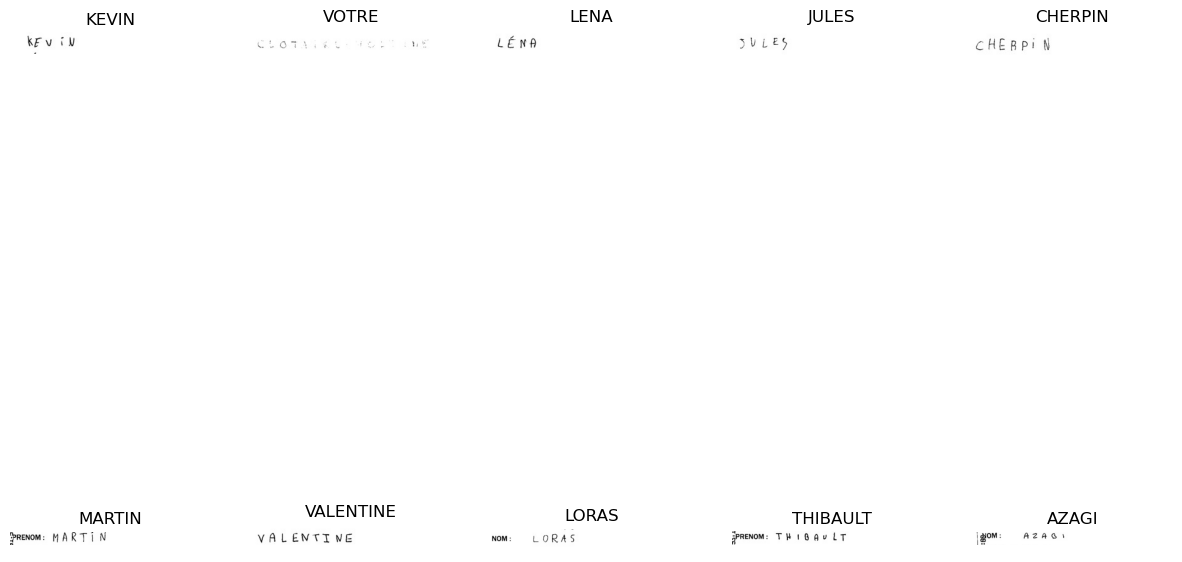

In [54]:
plt.figure(figsize=(15, 10))
for i in range(10):
    ax = plt.subplot(2, 5, i+1)   
    img_dir = 'D:/WorkStation/Datasets/archive/test_v2/test/'+test_name.loc[i, 'FILENAME']
    image = Image.open(img_dir)
    plt.imshow(image, cmap='gray')
    image = cropImage(image)
    image = cv2.imread('result.png', cv2.IMREAD_GRAYSCALE)
    
    image = preprocessImage(image)
    
    image = image/255.
#     image = preprocessImage(image)
#     image = image/255.
    pred = model.predict(image.reshape(1, 256, 64, 1))
    decoded = K.get_value(K.ctc_decode(pred, input_length=np.ones(pred.shape[0])*pred.shape[1], 
                                       greedy=True)[0][0])
    predicted_word = autocorrect(num_to_label(decoded[0]))
    plt.title(predicted_word, fontsize=12)
    plt.axis('off')
    
plt.subplots_adjust(wspace=0.2, hspace=0.8)

1/1 [==============================] - 0s 44ms/step
The Model predicted: INIELLIOENT


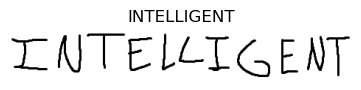

In [55]:
plt.figure(figsize=(15, 10))
#images = ['D:/WorkStation/Datasets/archive/test_v2/test/TEST_41355.jpg','D:/WorkStation/Datasets/archive/test_v2/test/TEST_41300.jpg','D:/WorkStation/Datasets/archive/test_v2/test/TEST_41354.jpg']
for i in range(1):
    ax = plt.subplot(2, 3, i+1)

    image = Image.open('D:/WorkStation/Datasets/archive/test_v2/test/test.png')
    plt.imshow(image, cmap='gray')
    image = cropImage(image)
    
    
#     image = cv2.imread('result2.png', cv2.COLOR_BGR2GRAY)
#     
#     image = imutils.skeletonize(gray, size=(3, 3))
    
#     cv2.imwrite('result2.png',image)
    image = cv2.imread('result2.png', cv2.IMREAD_GRAYSCALE)
    
    image = preprocessImage(image)
    
    image = image/255.
    
    pred = model.predict(image.reshape(1, 256, 64, 1))

    decoded = K.get_value(K.ctc_decode(pred, input_length=np.ones(pred.shape[0])*pred.shape[1], 
                                       greedy=True)[0][0])

    predicted_word = autocorrect(num_to_label(decoded[0]))
    plt.title(predicted_word, fontsize=12)
    print("The Model predicted: " +num_to_label(decoded[0]))
    plt.axis('off')

    
plt.subplots_adjust(wspace=0.2, hspace=-0.8)